In [1]:
import os
os.makedirs('~/.kaggle', exist_ok=True)
!cp kaggle.json ~/.kaggle/
os.chmod('/content/kaggle.json', 600)

cp: cannot create regular file '/root/.kaggle/': Not a directory


In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:17<00:00, 32.8MB/s]
100% 2.29G/2.29G [01:17<00:00, 31.7MB/s]


In [4]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import models


In [14]:
IMG_SIZE=(256,256)
chest_X_ray_train='/content/chest_xray/chest_xray/train'
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    chest_X_ray_train,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=32
)

Found 5216 files belonging to 2 classes.


In [50]:
class_names=train_dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

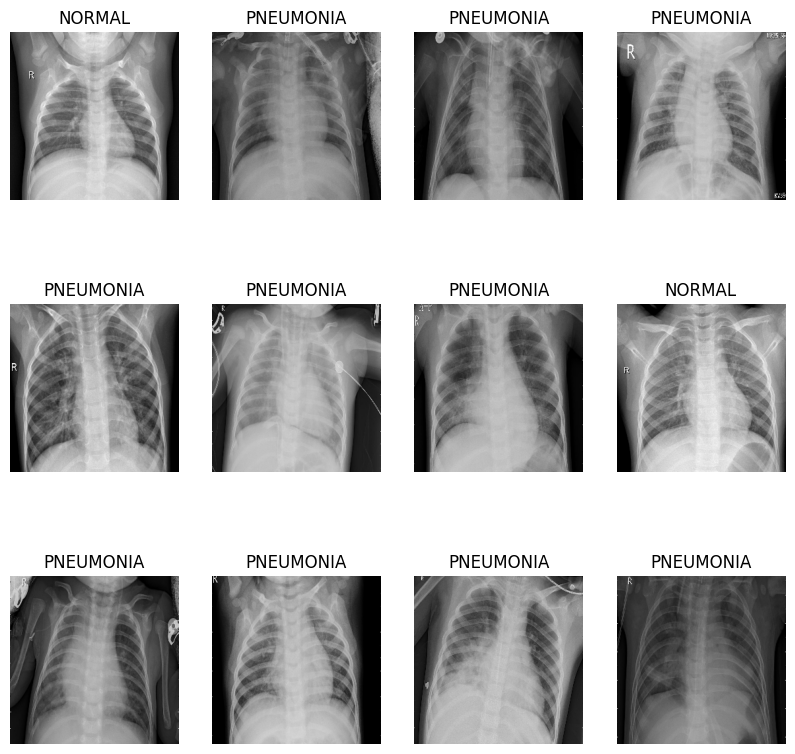

In [12]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [23]:
chest_X_ray_test='/content/chest_xray/chest_xray/test'
test_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    chest_X_ray_test,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=32
)
chest_X_ray_val='/content/chest_xray/chest_xray/val'
val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    chest_X_ray_val,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=32
)

Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [24]:
train_ds=train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [38]:
rescale=tf.keras.Sequential([

    tf.keras.layers.Rescaling(1.0/255)
])

In [39]:
data_augmentation=tf.keras.Sequential([
   tf.keras.layers.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.RandomRotation(0.2)
     ])



In [61]:
input_shape=(32,IMG_SIZE,IMG_SIZE,3)
model = models.Sequential([
    rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(128, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(128, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [62]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [63]:
history=model.fit(train_ds,epochs=50,batch_size=32,verbose=1,validation_data=val_ds)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.5000 - loss: 0.6969 - val_accuracy: 0.5000 - val_loss: 0.6956
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.4375 - loss: 0.7254 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.6875 - loss: 0.6675 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.3750 - loss: 0.8431 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.5625 - loss: 0.6756 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.4375 - loss: 0.7101 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.4375 - loss: 0.7024 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.5000 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6931


In [64]:
model.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 128s 6s/step - accuracy: 0.6092 - loss: 0.6929


[0.6928488612174988, 0.625]

In [65]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

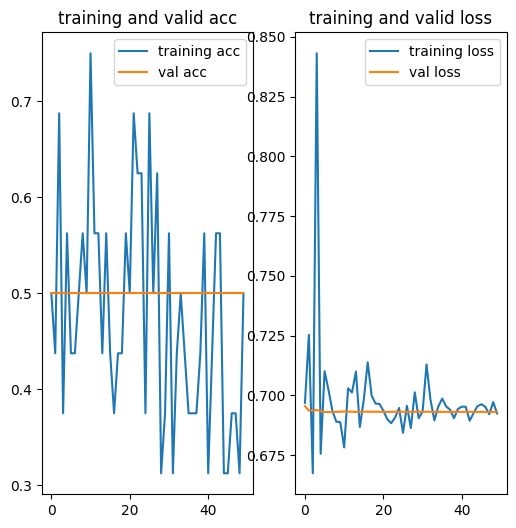

In [68]:
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.plot(acc,label='training acc')
plt.plot(val_acc,label='val acc')
plt.legend()
plt.title('training and valid acc')

plt.subplot(1,2,2)
plt.plot(loss,label='training loss')
plt.plot(val_loss,label='val loss')
plt.legend()
plt.title('training and valid loss')
plt.show()

actual label: NORMAL
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
predicted label NORMAL


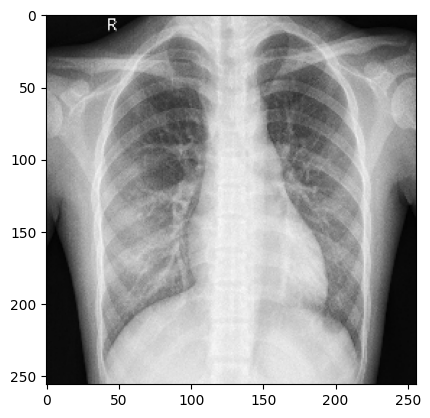

In [69]:
for image_batch,label_batch in test_ds.take(1):
  first_image=image_batch[0].numpy().astype('uint8')
  first_label=label_batch[0].numpy()
  plt.imshow(first_image)
  print('actual label:',class_names[first_label])
  batch_pred=model.predict(image_batch)
  print('predicted label',class_names[np.argmax(batch_pred[0])])

In [78]:
import pickle

In [79]:
with open('model-pickle','wb') as f:
  pickle.dump(model,f)

In [80]:
with open('model-pickle','rb') as f:
  models=pickle.load(f)

actual label: NORMAL
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
predicted label NORMAL


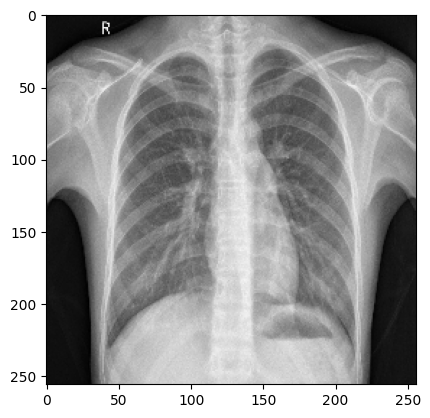

In [81]:
for image_batch,label_batch in test_ds.take(1):
  first_image=image_batch[0].numpy().astype('uint8')
  first_label=label_batch[0].numpy()
  plt.imshow(first_image)
  print('actual label:',class_names[first_label])
  batch_pred=models.predict(image_batch)
  print('predicted label',class_names[np.argmax(batch_pred[0])])